<a href="https://colab.research.google.com/github/A01364577/Equipo_18_Navegacion_Autonoma/blob/main/deteccion_de_peatones_Keras_LastVersion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Maestria en Inteligencia Artificial Aplicada
##Navegación Autónoma
###Actividad 4.1 - Ejercicio de clasificación con Keras
Equipo 18:

- Laura Irán González Ojeda - A01794099
- Emmanuel Francisco González Velázquez - A01364577
- Fabiola Sosa Hernández- A01240145
- Jorge Fernández Lara - A01793062
- Jonathan Puga Castellanos - A01795204

In [ ]:
# Importación de Librerías
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from xml.etree import ElementTree
import os
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from skimage.feature import hog
import numpy as np

In [ ]:
# Asegurarse de que se esté utilizando GPU
import tensorflow as tf
tf.test.gpu_device_name()
# Verificar si hay una GPU disponible
if tf.config.list_physical_devices('GPU'):
    print("GPU está disponible.")
    # Obtener detalles de la GPU
    for gpu in tf.config.list_physical_devices('GPU'):
        print(f"Nombre de la GPU: {gpu.name}")
else:
    print("No hay GPU disponible.")

GPU está disponible.
Nombre de la GPU: /physical_device:GPU:0


In [ ]:

# Cargar el archivo .json con el token de Kaggle y utilizar la API de Kaggle para descargar el archivo .zip del dataset
from google.colab import files
files.upload()

# Crear el directorio .kaggle y mover el archivo kaggle.json allí
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Instalar la API de Kaggle
!pip install kaggle

# Descargar el archivo del conjunto de datos de Kaggle
!kaggle datasets download -d karthika95/pedestrian-detection --unzip -p /content/pedestrian_dataset

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/karthika95/pedestrian-detection
License(s): unknown
 98% 184M/187M [00:01<00:00, 147MB/s]
100% 187M/187M [00:01<00:00, 139MB/s]


In [ ]:
# Se definen los nombres de las clases
class_names = ['person', 'person-like']
class_names_label = {name: i for i, name in enumerate(class_names)}

# Se definen los parámetros de la imagen
n_classes = 2
size = (200, 200)

In [ ]:
# Función para cargar y procesar las imágenes y etiquetas desde los directorios específicos para conjuntos de datos de entrenamiento, prueba y validación
def load_data():
    datasets = ['Train/Train', 'Test/Test', 'Val/Val']
    output = []

    for dataset in datasets:
        imags = []
        labels = []
        directoryA = "/content/pedestrian_dataset/" + dataset + "/Annotations"
        directoryIMG = "/content/pedestrian_dataset/" + dataset + "/JPEGImages/"
        file = os.listdir(directoryA)
        img = os.listdir(directoryIMG)
        file.sort()
        img.sort()

        i = 0
        for xml in file:
            xmlf = os.path.join(directoryA, xml)
            dom = ElementTree.parse(xmlf)
            vb = dom.findall('object')
            label = vb[0].find('name').text
            labels.append(class_names_label[label])

            img_path = directoryIMG + img[i]
            curr_img = cv2.imread(img_path)
            curr_img = cv2.resize(curr_img, size)
            imags.append(curr_img)
            i += 1

        imags = np.array(imags, dtype='float32')
        imags = imags / 255

        labels = np.array(labels, dtype='int32')
        output.append((imags, labels))
    return output

In [ ]:
(train_images, train_labels), (test_images, test_labels), (val_images, val_labels) = load_data()

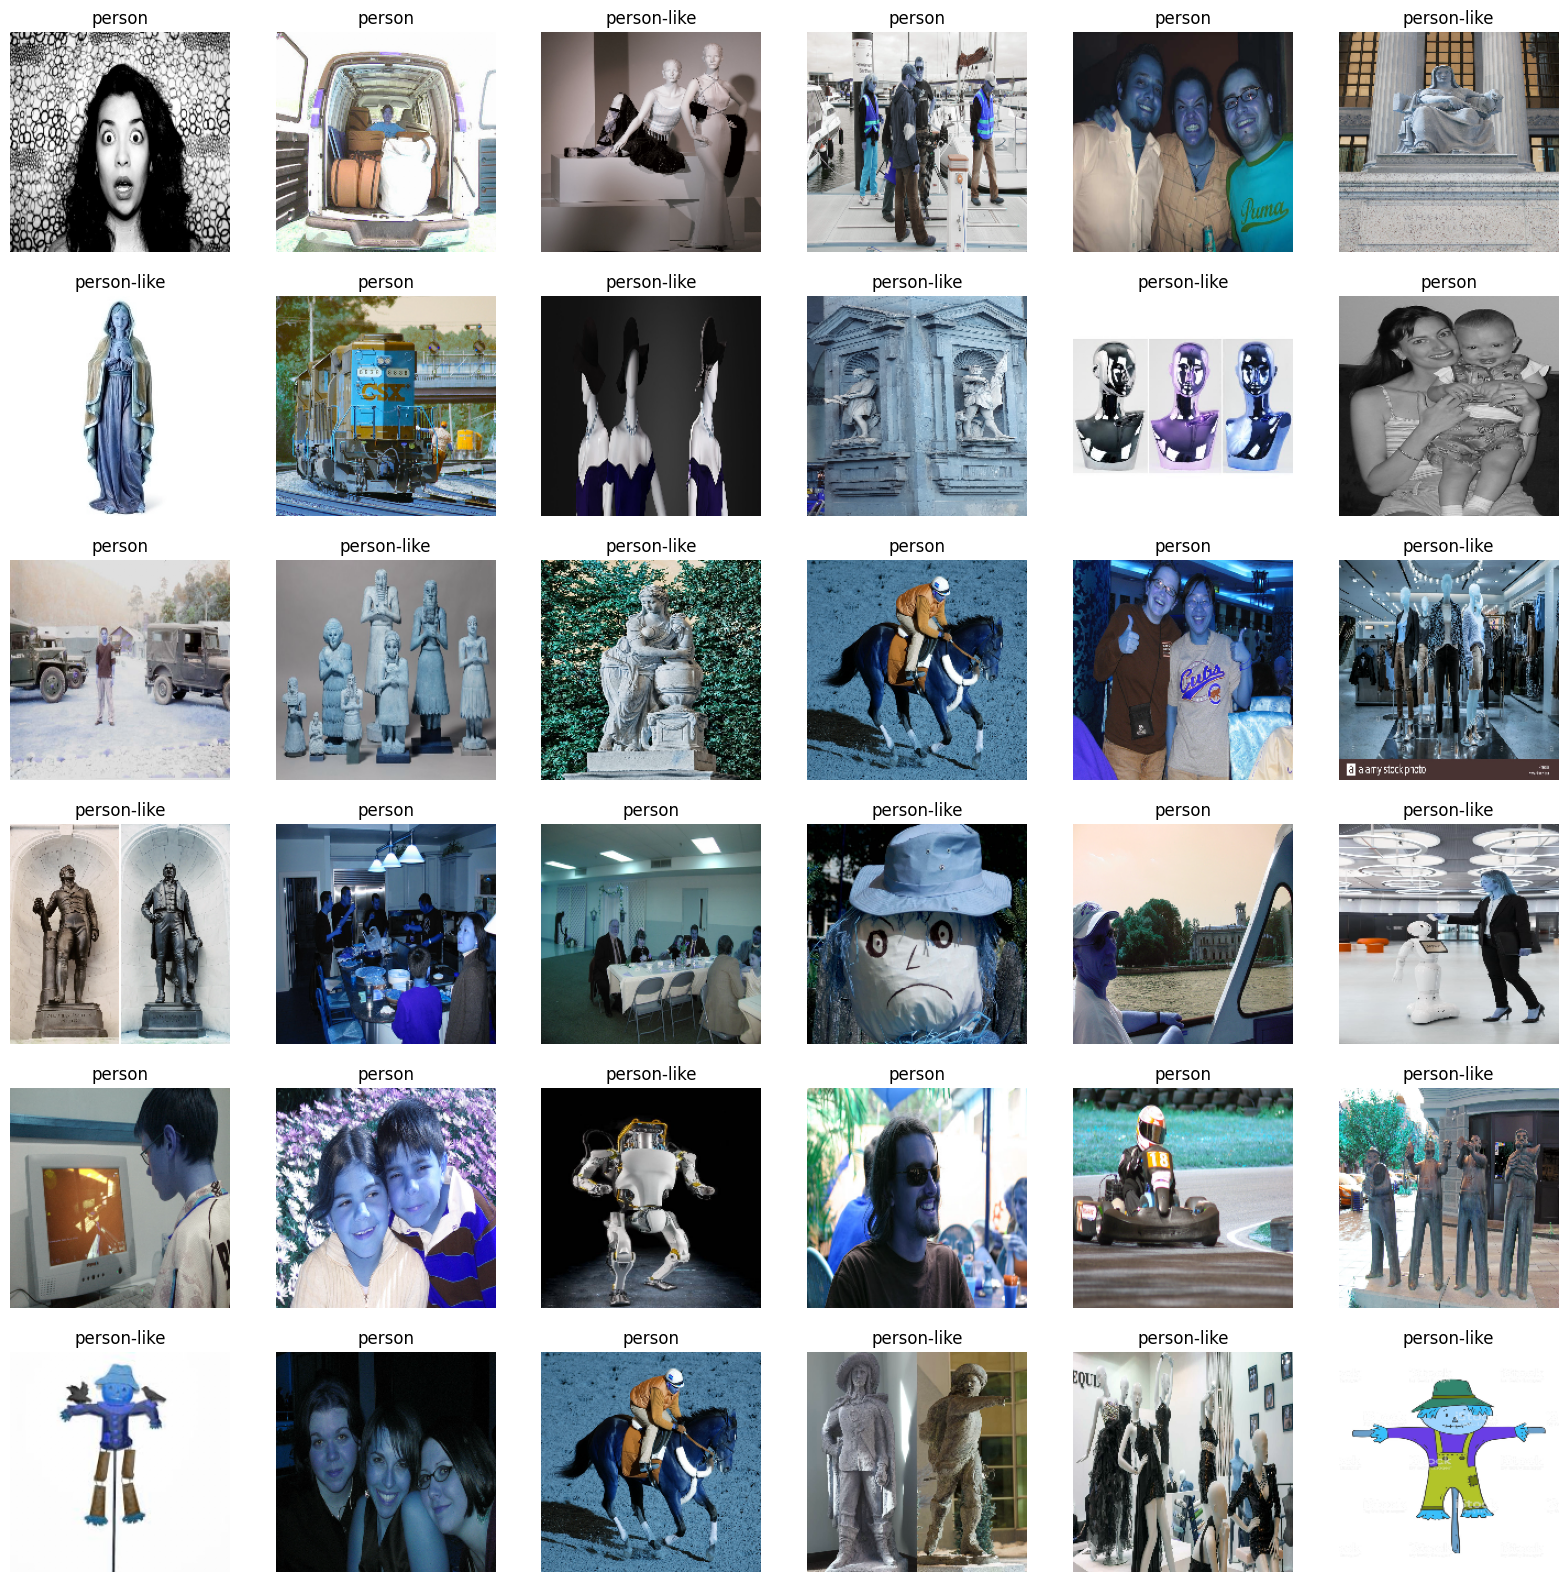

In [ ]:
# Visualización de algunas imágenes
plt.figure(figsize=(20, 20))
for n, i in enumerate(list(np.random.randint(0, len(train_images), 36))):
    plt.subplot(6, 6, n+1)
    plt.imshow(train_images[i])
    plt.title(class_names[train_labels[i]])
    plt.axis('off')
plt.show()

In [ ]:
print("Shape de train_images:", train_images.shape)
print("Shape de train_labels:", train_labels.shape)
print("Shape de val_images:", val_images.shape)
print("Shape de val_labels:", val_labels.shape)
print("Shape de test_images:", test_images.shape)
print("Shape de test_labels:", test_labels.shape)

Shape de train_images: (944, 200, 200, 3)
Shape de train_labels: (944,)
Shape de val_images: (160, 200, 200, 3)
Shape de val_labels: (160,)
Shape de test_images: (235, 200, 200, 3)
Shape de test_labels: (235,)


In [ ]:
# Extracción de HOG features
def extract_hog_features(images):
    hog_features_accum = []
    for img in images:
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        features, hog_img = hog(img_gray,
                                orientations=12,
                                pixels_per_cell=(16, 16),
                                cells_per_block=(2, 2),
                                transform_sqrt=True,
                                visualize=True,
                                feature_vector=True)
        hog_features_accum.append(features)
    return np.vstack(hog_features_accum).astype(np.float64)

In [ ]:
train_features = extract_hog_features(train_images)
test_features = extract_hog_features(test_images)
val_features = extract_hog_features(val_images)

In [ ]:
print("Shape de train_features:", train_features.shape)
print("Shape de train_labels:", train_labels.shape)

Shape de train_features: (944, 5808)
Shape de train_labels: (944,)


In [ ]:
# Normalización de los datos
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
train_features = scaler.fit_transform(train_features)
test_features = scaler.transform(test_features)
val_features = scaler.transform(val_features)

In [ ]:
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.layers import Dense, Dropout
keras = tf.keras

In [ ]:
train_features.shape

(944, 5808)

In [ ]:
# Creación del modelo de red neuronal
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2
model = models.Sequential()
model.add(layers.Conv2D(16, (3, 3), activation='relu', input_shape=(200, 200, 3), kernel_regularizer=l2(0.1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.01)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(2))

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD

#optimizer = SGD(learning_rate=0.001, momentum=0.15)
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              #loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_33 (Conv2D)          (None, 198, 198, 16)      448       
                                                                 
 max_pooling2d_18 (MaxPooli  (None, 99, 99, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_34 (Conv2D)          (None, 97, 97, 32)        4640      
                                                                 
 max_pooling2d_19 (MaxPooli  (None, 48, 48, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_35 (Conv2D)          (None, 46, 46, 64)        18496     
                                                                 
 flatten_9 (Flatten)         (None, 135424)          

In [ ]:
# Definir callbacks
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

In [ ]:
from sklearn.utils import class_weight
# Balancear clases
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(train_labels), y=train_labels)
class_weights_dict = dict(enumerate(class_weights))

In [ ]:
epochs=20
batch_size=64
# Entrenamiento del modelo
history = model.fit(train_images,
                    train_labels,
                    validation_data=(val_images, val_labels),
                    epochs=epochs,
                    batch_size=batch_size,
                    verbose=2,
                    callbacks=[early_stopping, reduce_lr],
                    class_weight=class_weights_dict)

Epoch 1/20
15/15 - 49s - loss: 3.7604 - accuracy: 0.5011 - val_loss: 3.7137 - val_accuracy: 0.4625 - lr: 1.0000e-04 - 49s/epoch - 3s/step
Epoch 2/20
15/15 - 1s - loss: 3.5984 - accuracy: 0.5477 - val_loss: 3.5327 - val_accuracy: 0.6250 - lr: 1.0000e-04 - 917ms/epoch - 61ms/step
Epoch 3/20
15/15 - 1s - loss: 3.4669 - accuracy: 0.6525 - val_loss: 3.4270 - val_accuracy: 0.6062 - lr: 1.0000e-04 - 826ms/epoch - 55ms/step
Epoch 4/20
15/15 - 1s - loss: 3.3360 - accuracy: 0.7055 - val_loss: 3.3518 - val_accuracy: 0.6250 - lr: 1.0000e-04 - 919ms/epoch - 61ms/step
Epoch 5/20
15/15 - 1s - loss: 3.2246 - accuracy: 0.7161 - val_loss: 3.2651 - val_accuracy: 0.5875 - lr: 1.0000e-04 - 979ms/epoch - 65ms/step
Epoch 6/20
15/15 - 1s - loss: 3.0999 - accuracy: 0.7775 - val_loss: 3.1343 - val_accuracy: 0.6750 - lr: 1.0000e-04 - 932ms/epoch - 62ms/step
Epoch 7/20
15/15 - 1s - loss: 2.9833 - accuracy: 0.8220 - val_loss: 3.0318 - val_accuracy: 0.7063 - lr: 1.0000e-04 - 967ms/epoch - 64ms/step
Epoch 8/20
15/15

In [ ]:
def plot_accuracy_loss(history):
    """
        Plot the accuracy and the loss during the training of the nn.
    """
    fig = plt.figure(figsize=(10,5))

    # Plot accuracy
    plt.subplot(221)
    plt.plot(history.history['accuracy'],'bo--', label = "acc")
    plt.plot(history.history['val_accuracy'], 'ro--', label = "val_acc")
    plt.title("train_acc vs val_acc")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    # Plot loss function
    plt.subplot(222)
    plt.plot(history.history['loss'],'bo--', label = "loss")
    plt.plot(history.history['val_loss'], 'ro--', label = "val_loss")
    plt.title("train_loss vs val_loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    plt.show()

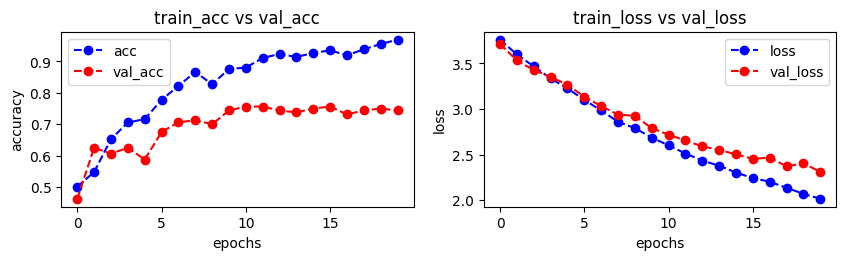

In [ ]:
plot_accuracy_loss(history)

In [ ]:
preds = model.predict(test_images)

8/8 [==============================] - 0s 13ms/step


In [ ]:
result = []
for i in range(len(preds)):
    result.append(np.argmax(preds[i]))

In [ ]:
tn, fp, fn, tp = confusion_matrix(test_labels,result).ravel()
(tn, fp, fn, tp)

(87, 49, 26, 73)

In [ ]:
# Cálculo de la matriz de confusión y clasificación
conf_matrix = confusion_matrix(test_labels,result)
#print(classification_report(test_labels, result))

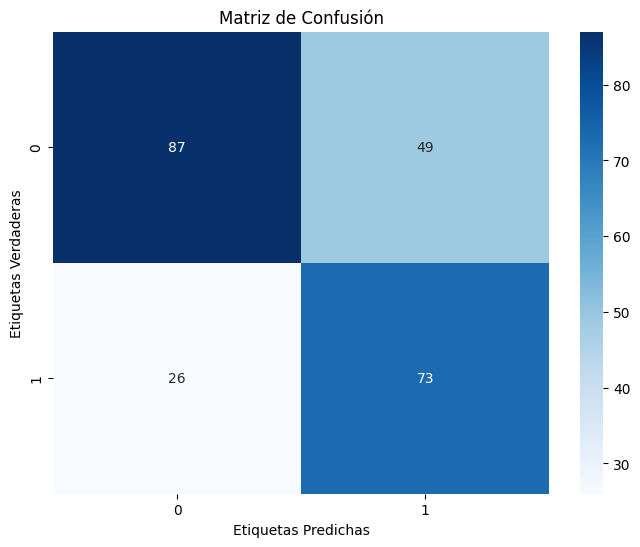

In [ ]:
# Visualización de la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')
plt.title('Matriz de Confusión')
plt.xlabel('Etiquetas Predichas')
plt.ylabel('Etiquetas Verdaderas')
plt.show()